In [2]:
!pip3 install neo4j

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [22]:
from neo4j import GraphDatabase

class HelloWorldExample:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def create_friendship(self, person1_name, person2_name):
        with self.driver.session() as session:
            greeting = session.execute_write(self._create_and_return_friendship, person1_name, person2_name)
            print(greeting)

    @staticmethod
    def _create_and_return_friendship(tx, person1_name, person2_name):
        query = (
            "CREATE (p1:Person {name: $person1_name}) "
            "CREATE (p2:Person {name: $person2_name}) "
            "CREATE (p1)-[:FRIEND]->(p2) "
            "RETURN p1.name AS person1, p2.name AS person2"
        )
        result = tx.run(query, person1_name=person1_name, person2_name=person2_name).single()
        if result is None:
            return "No result found."
        return f"Created friendship between: {result['person1']} and {result['person2']}"
    
    def find_persons(self):
        with self.driver.session() as session:
            persons = session.execute_read(self._find_and_return_persons)
            for person in persons:
                print(f"Found person: {person}")
            
    @staticmethod
    def _find_and_return_persons(tx):
        query = (
            "MATCH (person:Person) "
            "RETURN person.name AS name"
        )
        result = tx.run(query)
        return [record["name"] for record in result]
    
    def erase_database(self):
        with self.driver.session() as session:
            session.execute_write(self._erase_all)

    @staticmethod
    def _erase_all(tx):
        query = "MATCH (n) DETACH DELETE n"
        tx.run(query)

    def execute_custom(self, cypher_query):
        query_type = "insert" if "CREATE" in cypher_query or "MERGE" in cypher_query else "extract"
        
        with self.driver.session() as session:
            result = session.run(cypher_query)
            
            if query_type == "insert":
                return "Data insertion successful."
            else:
                return [record.data() for record in result]

# Replace 'neo4j://localhost:7687', 'neo4j', 'password' with your connection URI, username, and password
app = HelloWorldExample('neo4j://localhost:7687/graph-rag-test', 'neo4j', '12345678')

In [30]:
app.create_friendship('Alice', 'Bob')

Created friendship between: Alice and Bob


In [29]:
app.find_persons()

In [25]:
app.erase_database()

In [31]:
extracted_cypher = """CREATE (method:Method {name: "reasoning on graphs", description: "a novel method that synergizes LLMs with KGs to conduct faithful and interpretable reasoning"})
CREATE (framework:Framework {name: "planning-retrieval-reasoning", description: "a framework that generates relation paths grounded by KGs as faithful plans and retrieves valid reasoning paths from KGs to conduct faithful reasoning"})
CREATE (modulePlanning:Module {name: "planning", description: "a module that generates relation paths as plans"})
CREATE (modulePlanning)-[:PART_OF]->(framework)
CREATE (framework)-[:USES]->(method)
CREATE (moduleRetrievalReasoning:Module {name: "retrieval-reasoning", description: "a module that retrieves reasoning paths from KGs to conduct faithful reasoning"})
CREATE (moduleRetrievalReasoning)-[:PART_OF]->(framework)
CREATE (framework)-[:USES]->(method)
CREATE (moduleInference:Module {name: "inference", description: "a module that can be plug-and-play with different LLMs to improve their performance"})
CREATE (moduleInference)-[:PART_OF]->(method)
CREATE (benchmark:Dataset {name: "KGQA datasets", description: "benchmark datasets for KGQA"})
CREATE (taskPlanningOptimization:Task {name: "planning optimization", description: "optimization task where knowledge is distilled from KGs into LLMs to generate faithful relation paths as plans"})
CREATE (taskPlanningOptimization)-[:OPTIMIZES]->(method)
CREATE (taskRetrievalReasoningOptimization:Task {name: "retrieval-reasoning optimization", description: "optimization task where LLMs conduct faithful reasoning based on retrieved paths and generate interpretable results"})
CREATE (taskRetrievalReasoningOptimization)-[:OPTIMIZES]->(method)
CREATE (performanceSOTA:PerformanceMetric {name: "state-of-the-art performance", description: "achieving the best performance in KG reasoning tasks"})
CREATE (performanceSOTA)-[:ACHIEVED_BY]->(method)
CREATE (performanceFaithful:PerformanceMetric {name: "faithful and interpretable reasoning results", description: "generating reasoning results that are faithful and interpretable"})
CREATE (performanceFaithful)-[:ACHIEVED_BY]->(method)
"""
app.execute_custom(cypher_query=extracted_cypher)

'Data insertion successful.'

In [32]:
retreive_issues_cypher = """MATCH (source)-[r:OPTIMIZES]->(target)
RETURN source, r, target
"""
result = app.execute_custom(cypher_query=retreive_issues_cypher)

In [33]:
print(result)

[{'source': {'name': 'planning optimization', 'description': 'optimization task where knowledge is distilled from KGs into LLMs to generate faithful relation paths as plans'}, 'r': ({'name': 'planning optimization', 'description': 'optimization task where knowledge is distilled from KGs into LLMs to generate faithful relation paths as plans'}, 'OPTIMIZES', {'name': 'reasoning on graphs', 'description': 'a novel method that synergizes LLMs with KGs to conduct faithful and interpretable reasoning'}), 'target': {'name': 'reasoning on graphs', 'description': 'a novel method that synergizes LLMs with KGs to conduct faithful and interpretable reasoning'}}, {'source': {'name': 'retrieval-reasoning optimization', 'description': 'optimization task where LLMs conduct faithful reasoning based on retrieved paths and generate interpretable results'}, 'r': ({'name': 'retrieval-reasoning optimization', 'description': 'optimization task where LLMs conduct faithful reasoning based on retrieved paths an

In [34]:
app.execute_custom(cypher_query="""CREATE (runner:Runner {name: "Kelvin Kiptum Cheruiyot", nationality: "Kenyan", birth_date: date("1999-12-02"), death_date: date("2024-02-11")})
CREATE (record:Record {event: "marathon", time: "less than 2:02", record_type: "course record"})
CREATE (runner)-[:HOLDS_RECORD]->(record)
CREATE (achievement:Achievement {description: "the only person in history to run the marathon in less than two hours and one minute in a record-eligible race"})
CREATE (runner)-[:ACHIEVED]->(achievement)
CREATE (race1:Race {name: "Valencia Marathon 2022", date: date("2022-10-23"), time: "2:02", rank: "third"})
CREATE (runner)-[:PARTICIPATED_IN]->(race1)
CREATE (race2:Race {name: "London Marathon 2023", date: date("2023-04-23"), time: "2:01:25", rank: "second"})
CREATE (runner)-[:PARTICIPATED_IN]->(race2)
CREATE (race3:Race {name: "Chicago Marathon 2023", date: date("2023-10-23"), time: "2:00:35", rank: "first"})
CREATE (runner)-[:PARTICIPATED_IN]->(race3)
CREATE (ranking:Ranking {rank: 1, year: 2024, event: "men's marathon"})
CREATE (runner)-[:RANKED_FIRST_IN]->(ranking)
""")
result = app.execute_custom(cypher_query="""MATCH (source)-[r:PARTICIPATED_IN]->(target)
RETURN source, r, target
""")
print(result)

[{'source': {'nationality': 'Kenyan', 'birth_date': neo4j.time.Date(1999, 12, 2), 'name': 'Kelvin Kiptum Cheruiyot', 'death_date': neo4j.time.Date(2024, 2, 11)}, 'r': ({'nationality': 'Kenyan', 'birth_date': neo4j.time.Date(1999, 12, 2), 'name': 'Kelvin Kiptum Cheruiyot', 'death_date': neo4j.time.Date(2024, 2, 11)}, 'PARTICIPATED_IN', {'date': neo4j.time.Date(2022, 10, 23), 'name': 'Valencia Marathon 2022', 'rank': 'third', 'time': '2:02'}), 'target': {'date': neo4j.time.Date(2022, 10, 23), 'name': 'Valencia Marathon 2022', 'rank': 'third', 'time': '2:02'}}, {'source': {'nationality': 'Kenyan', 'birth_date': neo4j.time.Date(1999, 12, 2), 'name': 'Kelvin Kiptum Cheruiyot', 'death_date': neo4j.time.Date(2024, 2, 11)}, 'r': ({'nationality': 'Kenyan', 'birth_date': neo4j.time.Date(1999, 12, 2), 'name': 'Kelvin Kiptum Cheruiyot', 'death_date': neo4j.time.Date(2024, 2, 11)}, 'PARTICIPATED_IN', {'date': neo4j.time.Date(2023, 4, 23), 'name': 'London Marathon 2023', 'rank': 'second', 'time': '2

In [35]:
!pip3 install networkx matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


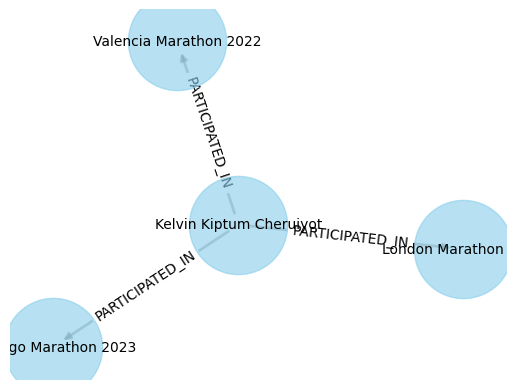

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph_data(data):
    G = nx.DiGraph()

    for item in data:
        source_name = None
        try:
            source_name = item['source']['name']
        except KeyError:
            source_name = str(item['source'])

        target_name = None
        try:
            target_name = item['target']['name']
        except KeyError:
            target_name = str(item['target'])
        relationship = item['r'][1]  # Assuming 'r' contains the relationship type in the second position
        
        # Add nodes
        G.add_node(source_name, **item['source'])
        G.add_node(target_name, **item['target'])
        
        # Add edge
        G.add_edge(source_name, target_name, relationship=relationship)

    pos = nx.spring_layout(G)  # positions for all nodes

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="skyblue", alpha=0.6)
    
    # Edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color="gray")
    
    # Node labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Edge labels
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')
    plt.show()

visualize_graph_data(result)


[{'source': {'nationality': 'Kenyan', 'name': 'Kelvin Kiptum Cheruiyot'}, 'r': ({'nationality': 'Kenyan', 'name': 'Kelvin Kiptum Cheruiyot'}, 'DIES_IN', {'date': 'February 2024'}), 'target': {'date': 'February 2024'}}]


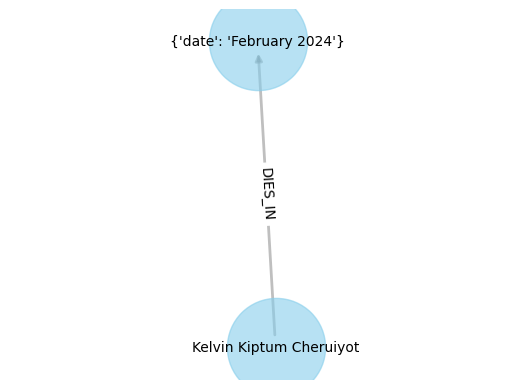

In [55]:
app.erase_database()
app.execute_custom(cypher_query="""CREATE (runner:Runner {name: "Kelvin Kiptum Cheruiyot", nationality: "Kenyan"})
CREATE (record:MarathonRecord {time: "less than two hours and one minute", date: "before February 2024"})
CREATE (runner)-[:HOLDS_RECORD]->(record)
CREATE (achievement:MarathonAchievement {description: "ran three of the seven fastest marathons in history"})
CREATE (runner)-[:ACHIEVES]->(achievement)
CREATE (marathon1:Marathon {name: "Valencia Marathon", year: 2022})
CREATE (marathon2:Marathon {name: "London Marathon", year: 2023})
CREATE (marathon3:Marathon {name: "Chicago Marathon", year: 2023})
CREATE (runner)-[:PARTICIPATED_IN]->(marathon1)
CREATE (runner)-[:PARTICIPATED_IN]->(marathon2)
CREATE (runner)-[:PARTICIPATED_IN]->(marathon3)
CREATE (marathon1)-[:FASTEST_TIME]->(time1:Time {time: "2:02"})
CREATE (marathon2)-[:FASTEST_TIME]->(time2:Time {time: "2:01:25"})
CREATE (marathon3)-[:FASTEST_TIME]->(time3:Time {time: "2:00:35"})
CREATE (achievement)-[:ACHIEVES_TIME]->(time1)
CREATE (achievement)-[:ACHIEVES_TIME]->(time2)
CREATE (achievement)-[:ACHIEVES_TIME]->(time3)
CREATE (debut:MarathonDebut {marathon: "Valencia Marathon", time: "2:02", description: "fastest-ever marathon debut"})
CREATE (runner)-[:ACHIEVES]->(debut)
CREATE (runner)-[:BREAKS_RECORD]->(record)
CREATE (crash:CarCrash {date: "February 2024"})
CREATE (runner)-[:DIES_IN]->(crash)
CREATE (ranking:MarathonRanking {rank: 1, year: 2024})
CREATE (runner)-[:RANKED_FIRST_IN]->(ranking)""")
result_llm = app.execute_custom(cypher_query="""MATCH (source)-[r:DIES_IN]->(target)
RETURN source, r, target
""")
print(result_llm)
visualize_graph_data(result_llm)

In [20]:
app.close()